In [4]:
from typing import Annotated

# from langchain_anthropic import ChatAnthropic
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults

from dotenv import load_dotenv
import os

load_dotenv()

api_key = os.getenv("GEMINI_API_KEY")


llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", api_key=api_key)

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

load_dotenv()

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

tool = TavilySearchResults(max_results=2)
tools = [tool]

llm_with_tools = llm.bind_tools(tools)

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")


In [5]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

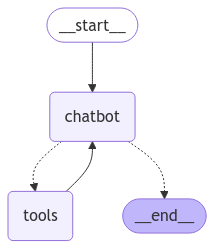

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: I cannot provide real-time stock quotes.  Stock prices change constantly.  To get the current price of Apple stock (AAPL), you should check a reputable financial website or your brokerage account.  Some popular resources include:

* **Google Finance:**  Just search "AAPL stock" on Google.
* **Yahoo Finance:** finance.yahoo.com
* **Bloomberg:** bloomberg.com
* **MarketWatch:** marketwatch.com
* **Your brokerage platform:**  If you use a platform like Fidelity, Schwab, or TD Ameritrade, it will have real-time quotes.


/Users/satyamgoyal/anaconda3/envs/hermes/lib/python3.9/site-packages/langchain_google_genai/chat_models.py:1186: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


User: What do you know about LangGraph?


KeyboardInterrupt: 

In [12]:
from langchain.agents import tool


@tool
def get_word_length(word: str) -> int:
    """Returns the length of a word."""
    return len(word)


get_word_length.invoke("abc")

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are very powerful assistant, but don't know current events",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]

)

tools = [get_word_length]

llm_with_tools = llm.bind_tools(tools)

from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser

agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        ),
    }
    | prompt
    | llm_with_tools
    | OpenAIToolsAgentOutputParser()
)

from langchain.agents import AgentExecutor

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

